# Trading News and Corporate Actions with BERT

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Algo-trading on corporate actions by leveraging NLP. A replicationa and enhancement of the paper: *Trade the Event: Corporate Events Detection for News-Based Event-Driven Trading (Zhou et al., Findings 2021)*.

We will perform the following steps:
1. Domain adaptation for financial articles by finetuning a BERT model with Masked Language Model (MLM) training on financial news and encyclopedia data. *Zhou et al.* utilized human annotators to label news articles with an event. 
1. Bi-Level Event Detection: At Token-Level we detect events using a sequence labeling approach. At the higher Article-Level we will augment the corpus with 'CLS' token embedding which contains the the aggregate of all the article's embeddings, and concatenate it with the lower level tokens.
1. Recognize security Ticker, using string matching algorithm to recognize tickers within articles.
1. Create trading signals on the identified tickers.

```bibtex
@inproceedings{zhou-etal-2021-trade,
    title = "Trade the Event: Corporate Events Detection for News-Based Event-Driven Trading",
    author = "Zhou, Zhihan  and
      Ma, Liqian  and
      Liu, Han",
    editor = "Zong, Chengqing  and
      Xia, Fei  and
      Li, Wenjie  and
      Navigli, Roberto",
    booktitle = "Findings of the Association for Computational Linguistics: ACL-IJCNLP 2021",
    month = aug,
    year = "2021",
    address = "Online",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2021.findings-acl.186",
    doi = "10.18653/v1/2021.findings-acl.186",
    pages = "2114--2124",
}
```

In [1]:
"""
%pip install matplotlib
%pip install tensorflow
%pip install tqdm
%pip install pip install transformers
"""

'\n%pip install matplotlib\n%pip install tensorflow\n%pip install tqdm\n%pip install pip install transformers\n'

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_PATH = "/kaggle/input/uscorpactionnews"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_PATH = "./data/"

Running in Kaggle...
/kaggle/input/uscorpactionnews/Event_detection/train.txt
/kaggle/input/uscorpactionnews/Event_detection/dev.txt
/kaggle/input/uscorpactionnews/Trading_benchmark/evaluate_news.json
/kaggle/input/uscorpactionnews/Domain_adapation/train.txt
/kaggle/input/uscorpactionnews/Domain_adapation/dev.txt


In [3]:
import numpy as np
import math
import shutil
import pandas as pd

from pathlib import Path
import re
import pickle
from copy import deepcopy

from tqdm import tqdm

import tensorflow as tf

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_ACCELERATOR_TYPE' in os.environ):
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_physical_devices('GPU')) > 0:
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-04-08 08:30:00.588356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 08:30:00.588510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 08:30:00.762785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running on CPU
Number of accelerators: 1


'/kaggle/working'

# Wrangling the Data

Our corpus will be processed and labelled to 11 types of corporate events: 
1. Acquisition(A)
1. Clinical Trial(CT)
1. Regular Dividend(RD)
1. Dividend Cut(DC)
1. Dividend Increase(DI)
1. Guidance Increase(GI)
1. New Contract(NC)
1. Reverse Stock Split(RSS)
1. Special Dividend(SD)
1. Stock Repurchase(SR)
1. Stock Split(SS).
1. No event (O)

Articles are structured as follows:

```json
'title': 'Title',
'text': 'Text Body',
'pub_time': 'Published datetime',
'labels': {
    'ticker': 'Security symbol',
    'start_time': 'First trade after article published',
    'start_price_open': 'The "Open" price at start_time',
    'start_price_close': 'The "Close" price at start_time',
    'end_price_nday': 'The "Close" price at the last minute of the following 1-3 trading day. If early than 4pm ET its the same day. Otherwise, it refers to the next trading day.', 
    'end_time_1-3day': 'The time corresponds to end_price_1day',
    'highest_price_nday': 'The highest price in the following 1-3 trading', 
    'highest_time_nday': 'The time corresponds to highest_price_1-3day',
    'lowest_price_nday': 'The lowest price in the following 1-3 trading day',
    'lowest_time_nday': 'The time corresponds to lowest_price_1-3day',
}
```

In [4]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, BertConfig, BertTokenizerFast, TFBertModel, BertTokenizer, TFBertForTokenClassification, BertConfig, create_optimizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

MODEL_DIR = 'google-bert/bert-base-cased'
MAX_LEN = 256
SPECIAL_TOKEN = '[CLS]'
NUM_LABELS = 12 # See Labels description above.

### Tokenizing News Text

The text body is tokenized, a simple example is shown below, including how the '[CLS]' token is leveraged. BERT's transformer inputs expect of shape [batch_size, seq_length] the following inputs:
- "input_ids": token ids of the input sequences.
- "attention_mask": has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.
- "token_type_ids": the index of the input that created the input token. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0.

Transformers use self-attention mechanisms represent interactions amongst tokens and their contextual information in the input sequence as a weighted-sum. With this mechanism higher layers of the network will aggregate information from all other tokens in the sequence, in our case '[CLS]' will have such information. 


In [5]:
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
model = TFBertModel.from_pretrained(MODEL_DIR)

text = ["Further this conclusion is the fact that cumulative raw returns increase and exceed the market over the same period. When taken as a whole, the evidence suggests Cramer recommends “hot” stocks, lending credence to the Hot Hand Fallacy in this context. "]

inputs = tokenizer.encode_plus(f"{SPECIAL_TOKEN} {text}", return_tensors="tf")
outputs = model(inputs['input_ids'])
hidden_state = outputs.last_hidden_state
embedding = hidden_state[:, 0, :] # Get the hidden state with all info.

inputs

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

{'input_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[  101,   101,   164,   112,  6940,  1142,  6593,  1110,  1103,
         1864,  1115, 27574,  7158,  5166,  2773,  1105, 13908,  1103,
         2319,  1166,  1103,  1269,  1669,   119,  1332,  1678,  1112,
          170,  2006,   117,  1103,  2554,  5401,   140,  4515,  1200,
        18029,  1116,   789,  2633,   790, 17901,   117, 21363,   172,
         4359,  7008,  1106,  1103,  4126,  9918,  6760, 15347,  1107,
         1142,  5618,   119,   112,   166,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1

In [6]:
def read_wnut(file_path):
    """
    Reads a WNUT-format file to extract and separate tokens and their NER tags.
    The WNUT-format expects each token and its corresponding tag to be separated by a tab ('\t'),
    with each token-tag pair on a new line. Different documents or sentences are separated by
    a blank line.

    Args:
        file_path (str): The path to the WNUT-format file containing the annotated text.

    Returns:
        tuple: A tuple containing two lists:
            - token_docs: A list where each element is a list of tokens from a single document/sentence.
            - tag_docs: A list where each element is a list of tags corresponding to the tokens in the `token_docs`.
    """
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

def encode_tags(tags, encodings, tag2id):
    """
    Aligns NER tags with the tokenized input for models employing subword tokenization, such as BERT, that requires adjusting the original word-level tags to match the tokenized structure.
    Note the ignore value (-100, from  PyTorch's CrossEntropyLoss) used for tokens that should not be directly associated with a tag from the original dataset, such as special tokens added during tokenization ([CLS], [SEP], [PAD]).

    Args:
        tags (list of list of str): The original list of tag sequences for each document.
        encodings (transformers.BatchEncoding): The tokenized input data with `offset_mapping` included.
        tag2id (dict): A mapping from tag names to unique integer IDs.

    Returns:
        list of list of int: A list of adjusted label sequences for each document, aligned with the tokenized input.
    """
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * -100
        arr_offset = np.array(doc_offset)
        max_len = len(doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)])
        doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)] = doc_labels[:max_len]
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

def load_and_cache_dataset(path=DATA_PATH, model=MODEL_DIR, max_len=MAX_LEN, num_labels=NUM_LABELS, cache=True):
    """
    Preprocesses and caches the NER dataset for training with a BERT model.

    Loads training and testing data withs sentences and their corresponding NER tags. It consolidates all unique NER tags from both datasets into a tag2id dictionary, mapping each tag to a unique integer, and its inverse id2tag.
    Computes sequence-level labels for both datasets, where each sequence is represented by a binary label vector indicating the presence of specific tags and Tokenizes and encodes the text data, adjusting for BERT's subword tokenization and removing offset mappings as they're not used in model training.

    NER tags are adjusted to align with the tokenizer's output, transforming them into a numerical format suitable for training.
    Args:
        path (str): Path to the dataset directory.
        model (str): Directory of the pretrained BERT model to use for tokenization.
        max_len (int): Maximum sequence length for tokenization.
        num_labels (int): Number of unique labels in the dataset.
        cache (bool): Caches output, defaults to True.

    Returns:
        Tuple: Processed training and testing encodings, sequence labels, and NER labels.
    """
    def generate_sequence_labels(tags_list, tag2id, num_labels):
        """
        Generates sequence labels for a list of tag sequences.

        Args:
            tags_list (list of list of str): List of tag sequences.
            tag2id (dict): Mapping from tag names to unique integer IDs.
            num_labels (int): Number of unique labels in the dataset.

        Returns:
            list of list of int: Sequence labels for each tag sequence.
        """
        seq_labels = []
        for tags in tqdm(tags_list, desc="generate_sequence_labels"):
            tag_set = set(tags)
            current_label = np.zeros([num_labels])
            if len(tag_set) == 1:
                current_label[tag2id['O']] = 1
            else:
                tag_set.discard('O')
                for tag in tag_set:
                    current_label[tag2id[tag]] = 1
            seq_labels.append(list(current_label))
        return seq_labels

    cache_file = os.path.join(path, f'cached_train_test_{max_len}.pkl')

    if cache and os.path.exists(cache_file):
        print("Loading dataset from cache")
        with open(cache_file, 'rb') as f:
            train_encodings, train_seq_labels, train_ner_labels, test_encodings, test_seq_labels, test_ner_labels = pickle.load(f)

        return train_encodings, train_seq_labels, train_ner_labels, test_encodings, test_seq_labels, test_ner_labels

    tokenizer = BertTokenizerFast.from_pretrained(model)
    train_ner_texts, train_ner_tags = read_wnut(os.path.join(path, 'Event_detection/train.txt'))
    test_ner_texts, test_ner_tags = read_wnut(os.path.join(path, 'Event_detection/dev.txt'))
    tags = deepcopy(train_ner_tags)
    tags.extend(test_ner_tags)

    unique_tags = list(set(tag for doc in train_ner_tags for tag in doc))
    tag2id = {tag: id for id, tag in enumerate(sorted(unique_tags))}
    print(f"Tags to identify: {tag2id}")
    id2tag = {id: tag for tag, id in tag2id.items()}

    train_seq_labels = []
    test_seq_labels = []
    train_seq_labels = generate_sequence_labels(train_ner_tags, tag2id, num_labels)
    test_seq_labels = generate_sequence_labels(test_ner_tags, tag2id, num_labels)

    train_encodings = tokenizer(train_ner_texts,
                                is_split_into_words=True,
                                return_offsets_mapping=True,
                                padding='max_length',
                                truncation=True,
                                max_length=max_len)
    test_encodings = tokenizer(test_ner_texts,
                            is_split_into_words=True,
                            return_offsets_mapping=True,
                            padding='max_length',
                            truncation=True,
                            max_length=max_len)

    train_ner_labels = encode_tags(train_ner_tags, train_encodings, tag2id)
    test_ner_labels = encode_tags(test_ner_tags, test_encodings, tag2id)
    train_encodings.pop("offset_mapping")
    test_encodings.pop("offset_mapping")
    if cache:
        data_to_save = (
        train_encodings, train_seq_labels, train_ner_labels, test_encodings, test_seq_labels, test_ner_labels)
        with open(cache_file, 'wb') as f:
            pickle.dump(data_to_save, f)

    return train_encodings, train_seq_labels, train_ner_labels, test_encodings, test_seq_labels, test_ner_labels

train_encodings, train_seq_labels, train_ner_labels, test_encodings, test_seq_labels, test_ner_labels =  load_and_cache_dataset(DATA_PATH, cache=not IN_KAGGLE)

input_ids = np.array(train_encodings['input_ids'])
attention_mask = np.array(train_encodings['attention_mask'])
token_type_ids = np.array(train_encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None
labels = np.array(train_seq_labels)
ner = np.array(train_ner_labels)
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
if token_type_ids is not None:
    print("token_type_ids shape:", token_type_ids.shape)
else:
    print("token_type_ids not present")

print("seq_labels shape:", labels.shape)
print("ner_labels shape:", ner.shape)

Tags to identify: {'I-A': 0, 'I-CT': 1, 'I-DC': 2, 'I-DI': 3, 'I-GC': 4, 'I-NC': 5, 'I-RD': 6, 'I-RSS': 7, 'I-SD': 8, 'I-SR': 9, 'I-SS': 10, 'O': 11}


generate_sequence_labels: 100%|██████████| 1948/1948 [00:00<00:00, 75739.07it/s]


input_ids shape: (7770, 256)
attention_mask shape: (7770, 256)
token_type_ids shape: (7770, 256)
seq_labels shape: (7770, 12)
ner_labels shape: (7770, 256)


### Attention is all you Need

Vaswani et. al seminal paper *Attention is All You Need*, made self-attention and transformers mainstream.

Self-attention, calculates the relevance of each word in a sentence to every other word. This is done through queries (Q=XW^Q), keys (K=XW^K), and values (V=XW^V) transformed by a learned weight matrix (W) from the input embeddings (X). The attention score between two words is computed by taking the dot product of their queries and keys, followed by a softmax:

$ \text{A}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $

Where:
- Q represents the queries matrix of current items,
- K represents the keys matrix of items to compare against in the input sequence,
- V represents the values matrix, which are the dot product comparisons between Q and K,
- d_k represents the dimension of the keys and queries,
- A are the Attention wieghts.

In addition, the word embeddings will contain contextual information (dot poduct of A and V), represented as position added to the embedding. This plus the attention wieghts, captures dependencies and relationships.

## BERT Classifier

Built on top of a pretrained BERT (Bidirectional Encoder Representations from Transformers).BERT is an industry tested transformer-based model, pre-trained on a large corpus of text to generate contextual embeddings for input sequences.

We will use a small pre-trained cased base model with 12-layers + 768-hidden, 12-heads , and 110M parameters. This is the base model used in *Zhou et al. (2021)*. Later in the article, we will use larger BERT models that are more resource demanding to fine-tune. Each model has its own preprocesser, as text inputs need to be converted to token IDs.

The architecture can be summarized in 3 componets:
1. Input embeddings, attention masks and ID types for the preTrained BERT model. Bert applies transformer blocks with self-attention (attention captures language structures). The model outputs embedding sequences (last layer from BERT NxH) and a pooled summary derived from the first 'CLS' token(a 1XH vector).
1. The sequence outputs (NxH vector) is passed through dense layers and dropouts for the first NER classification, this maps the high-DIM outputs to logits. Padding of unknown tokens helps the model focus on the tasks.
1. NER logits are flattened and concatenated with the pooled summaries to form a new feature vector (NxH + H). The vector is passed again through dense and dropout layers to classify the event as one of the 11 identified (O is ignored).

In [7]:
class TFBertForBilevelClassification(tf.keras.Model):
    def __init__(self, config, max_seq_length, *args, **kwargs):
        super().__init__()
        self.num_labels = config.num_labels
        self.max_seq_length = max_seq_length

        self.bert = TFBertModel(config)

        self.ner_dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.ner_classifier1 = tf.keras.layers.Dense(2048, activation='relu')
        self.ner_classifier2 = tf.keras.layers.Dense(self.num_labels, activation='softmax')  # Assuming softmax for classification

        self.final_dropout1 = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.final_classifier1 = tf.keras.layers.Dense(2048, activation='relu')
        self.final_dropout2 = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.final_classifier2 = tf.keras.layers.Dense(self.num_labels - 1, activation='sigmoid')  # Assuming binary classification

        self.seq_dropout = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.dropout1 = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.dropout2 = tf.keras.layers.Dropout(config.hidden_dropout_prob)

    def call(self, inputs, training=False):
        input_ids, attention_mask, token_type_ids = inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = bert_outputs['last_hidden_state']
        pooled_output = bert_outputs['pooler_output']

        sequence_output = self.ner_dropout(sequence_output, training=training)
        ner_logits = self.ner_classifier1(sequence_output)
        ner_logits = self.dropout1(ner_logits, training=training)
        ner_logits = self.ner_classifier2(ner_logits)

        pad_pred = tf.zeros((self.num_labels,), dtype=ner_logits.dtype)
        pad_pred = tf.tensor_scatter_nd_update(pad_pred, [[self.num_labels - 1]], [1])
        pad_pred = tf.expand_dims(pad_pred, 0)  # Expanding dimensions to match ner_logits for broadcasting.
        mask_expanded = tf.expand_dims(attention_mask, -1)
        ner_logits = tf.where(tf.equal(mask_expanded, 0), pad_pred, ner_logits)

        ner_logits_flat = tf.reshape(ner_logits, [-1, self.max_seq_length * self.num_labels ])
        final_input = tf.concat([pooled_output, ner_logits_flat], axis=1)

        seq_logits = self.final_dropout1(final_input, training=training)
        seq_logits = self.final_classifier1(seq_logits)
        seq_logits = self.final_dropout2(seq_logits, training=training)
        seq_logits = self.final_classifier2(seq_logits)

        return ner_logits, seq_logits


    def custom_ner_loss(self, ner_logits, ner_labels, attention_mask):
        ner_loss_fct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        ner_logits_flat = tf.reshape(ner_logits, [-1, self.num_labels])
        ner_labels_flat = tf.reshape(ner_labels, [-1])
        attention_mask_flat = tf.reshape(attention_mask, [-1])

        ignore_mask = tf.not_equal(ner_labels_flat, -100)
        active_loss = tf.where(tf.equal(attention_mask_flat, 1), ignore_mask, tf.zeros_like(ignore_mask, dtype=tf.bool))
        ner_labels_filtered = tf.boolean_mask(ner_labels_flat, active_loss)
        ner_logits_filtered = tf.boolean_mask(ner_logits_flat, active_loss)

        ner_loss = ner_loss_fct(ner_labels_filtered, ner_logits_filtered)

        return tf.reduce_sum(ner_loss) / tf.cast(tf.reduce_sum(tf.cast(active_loss, dtype=tf.float32)), tf.float32)

    def custom_seq_loss(self, seq_logits, seq_labels):
        seq_labels_modified = seq_labels[:, :-1]
        seq_loss_fct = BinaryCrossentropy(from_logits=True)
        seq_loss = seq_loss_fct(seq_labels_modified, seq_logits)

        return seq_loss

    def train_step(self, data):
        inputs, labels = data
        with tf.GradientTape() as tape:
            ner_logits, seq_logits = self(inputs, training=True)
            ner_loss = self.custom_ner_loss(ner_logits, labels['ner_labels'], inputs['attention_mask'])
            seq_loss = self.custom_seq_loss(seq_logits, labels['seq_labels'])
            total_loss = ner_loss + seq_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'loss': total_loss, 'ner_loss': ner_loss, 'seq_loss': seq_loss}

config = BertConfig.from_pretrained(MODEL_DIR)
config.num_labels = NUM_LABELS
model = TFBertForBilevelClassification(config, MAX_LEN)

input_ids = np.array(train_encodings['input_ids'])
attention_mask = np.array(train_encodings['attention_mask'])
token_type_ids = np.array(train_encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids
    },
    {
        'ner_labels': np.array(train_ner_labels),
        'seq_labels': np.array(train_seq_labels)
    }
))

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32)

optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer)
model.fit(train_dataset, epochs=3)
model.summary()

Epoch 1/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 4327s 18s/step - loss: 1.7966 - ner_loss: 1.6878 - seq_loss: 0.1162
Epoch 2/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 4366s 18s/step - loss: 1.7689 - ner_loss: 1.6734 - seq_loss: 0.1028
Epoch 3/3
243/243 ━━━━━━━━━━━━━━━━━━━━ 4379s 18s/step - loss: 1.7684 - ner_loss: 1.6734 - seq_loss: 0.1023


Model: "tf_bert_for_bilevel_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │        24,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │     7,866,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │        22,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,465,223 (108.59 MB)

 Trainable params: 9,488,407 (36.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,976,816 (72.39 MB)

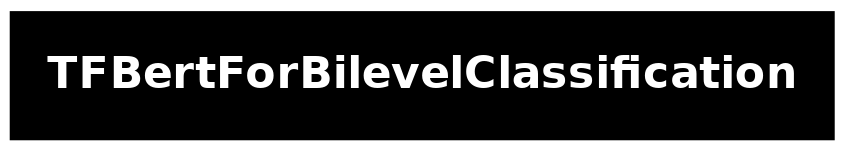

In [8]:
tf.keras.utils.plot_model(model)

# Conclusion

TODO

## References

- [Zhou, Zhihan, Liqian Ma, and Han Liu. "Trade the event: Corporate events detection for news-based event-driven trading." arXiv preprint arXiv:2105.12825 (2021).](https://aclanthology.org/2021.findings-acl.186)
- [Hugging Face Transformers APIs](https://github.com/huggingface/transformers)
- [Hugging Face Model Repository and Spaces](https://huggingface.co/models)
- [Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).](https://arxiv.org/abs/1810.04805)
- [Google Pre-trained BERT Models.](https://github.com/google-research/bert?tab=readme-ov-file)
- [Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin, "Attention is All You Need". NIPS (2017)](https://research.google/pubs/attention-is-all-you-need/)

## Github

Article and code available on [Github](https://github.com/adamd1985/news-based-event-driven_algotrading)

Kaggle notebook available [here]()

Google Collab available [here]()

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.